# Topic Clustering

1. Use an embedding model, e.g., bge-en-base-v1.5 to extract embedding vector of each event.
2. Use t-SNE to visualize the manifold of all articles.

In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES='8'

env: CUDA_VISIBLE_DEVICES='8'


In [79]:
import pandas as pd
from FlagEmbedding import FlagModel
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import json
from more_itertools import chunked, flatten
import faiss
from UF import UF
import numpy as np
import seaborn as sns

pd.set_option('max_colwidth', 100)


# torch.cuda.is_available = lambda: False
# torch.cuda.device_count = lambda: 0

In [6]:
def create_input_text(d: dict) -> str:
    event_type = d["event_type"].lower()
    trigger = d["trigger"].lower()
    summary = d["event_summary"].lower()
    return f"Event type: {event_type}. Trigger: {trigger}. Summary: {summary}"

In [7]:
articles = json.load(open("../data/events.json"))

In [8]:
events = list(flatten(article["events"] for article in articles))
input_texts = [create_input_text(event) for event in events]

In [10]:
events_df = pd.DataFrame(events)

In [11]:
events_df.head()

,event_id,event_type,trigger,event_summary,arguments,dependencies
0,1,Economic Warning,warn of inflation risks,Federal Reserve officials warned that the Trum...,"{'agent': 'Federal Reserve officials', 'object...",[]
1,2,Trade Policy,slapped tariffs,President Trump announced new tariffs on the t...,"{'agent': 'President Trump', 'object': 'goods ...",[]
2,3,Diplomatic Agreement,suspending the tariffs,Trump agreed to suspend tariffs on Mexico and ...,"{'agent': 'President Trump', 'object': 'tariff...","[{'event_id': 2, 'relation_type': 'RESPONSE_TO..."
3,4,Economic Analysis,will push up inflation and depress growth,Economists predict the new tariffs will increa...,"{'agent': 'Economists', 'object': 'US economy'...","[{'event_id': 2, 'relation_type': 'CONSEQUENCE..."
4,5,Monetary Policy,held policy rate steady,The Federal Reserve decided to keep interest r...,"{'agent': 'Federal Reserve', 'object': 'intere...","[{'event_id': 2, 'relation_type': 'INFLUENCED'..."


# Event Embedding Extraction

In [12]:
bge = FlagModel("BAAI/bge-base-en-v1.5", use_fp16=True)
# bge.model.to("cpu")
# bge.device = torch.device("cpu")


In [14]:
embeddings = bge.encode(input_texts)
#embeddings = [encode(chunk) for chunk in tqdm(list(chunked(articles, 10)))]

Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [12:13<00:00,  5.52s/it]


In [15]:
events_df['bge_embedding'] = embeddings.tolist()

In [17]:
events_df.to_parquet("../data/emb_output.parquet", engine="pyarrow")

In [ ]:
colors = ['blue'] * len(df)

In [ ]:
plot_2d(embeddings, colors, perplexity=30)

# Event Clustering

In [40]:
events_df['event_id'] = np.arange(len(events_df))

In [41]:
D = 768
K = 768//2
index = faiss.IndexPQ(D, K, 8)

In [42]:
index.train(embeddings)
index.add(embeddings)

In [ ]:
TOP_K = 100
distance_matrix, index_matrix = index.search(np.array(embeddings), TOP_K)

In [73]:
THRESHOLD = 0.1
N = len(events_df)
uf = UF(N)
events_df['cluster_id'] = events_df['event_id']
for cur_i, (distances, indexes) in tqdm(enumerate(zip(distance_matrix, index_matrix))):
    for d, i in zip(distances, indexes):
        if d >= THRESHOLD: break
        uf.union(events_df.iloc[cur_i].event_id, events_df.iloc[i].event_id) 

0it [00:00, ?it/s]

In [74]:
# reassign cluster_id
events_df['cluster_id'] = events_df['cluster_id'].apply(uf.find)

In [75]:
events_df['cluster_id'].value_counts()

cluster_id
272      158
23168     75
33954     40
25670     26
33002     24
        ... 
11728      1
11727      1
11725      1
11724      1
11740      1
Name: count, Length: 31986, dtype: int64

In [108]:
def plot_2d(events_df, perplexity=5):
   tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)  # Adjust perplexity based on your dataset
   embeddings = np.array(events_df['bge_embedding'].tolist())
   embeddings_2d = tsne.fit_transform(embeddings)
   events_df['x'] = embeddings_2d[:, 0]
   events_df['y'] = embeddings_2d[:, 1]
   sns.scatterplot(events_df, x='x', y='y', hue='cluster_id', s=10, palette="deep")

In [109]:
top_clusters = events_df['cluster_id'].value_counts().head(10).index
top_events = events_df[events_df.cluster_id.isin(top_clusters)]

/mnt/raid-s3/usr/khoa/dev/TemporalLens/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/raid-s3/usr/khoa/dev/TemporalLens/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_700946/737761268.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['x'] = embeddings_2d[:, 0]
/tmp/ipykernel_700946/737761268.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

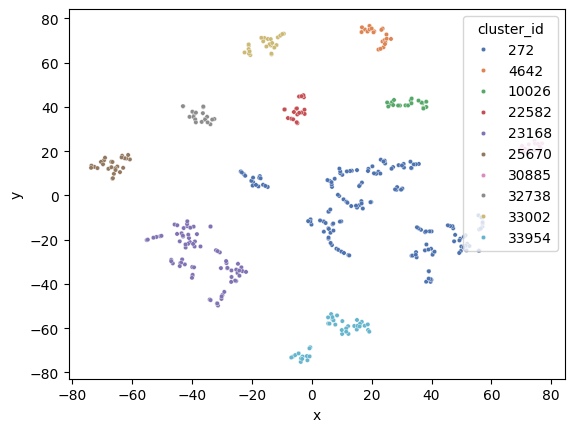

In [110]:
plot_2d(top_events)